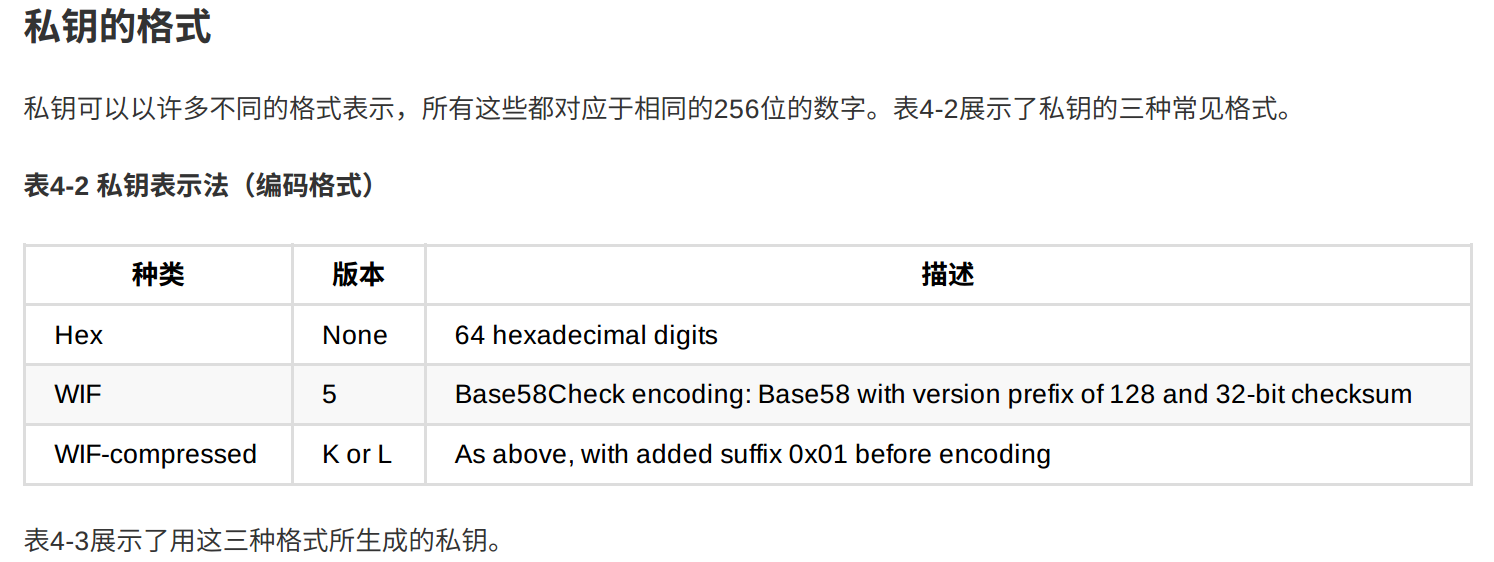

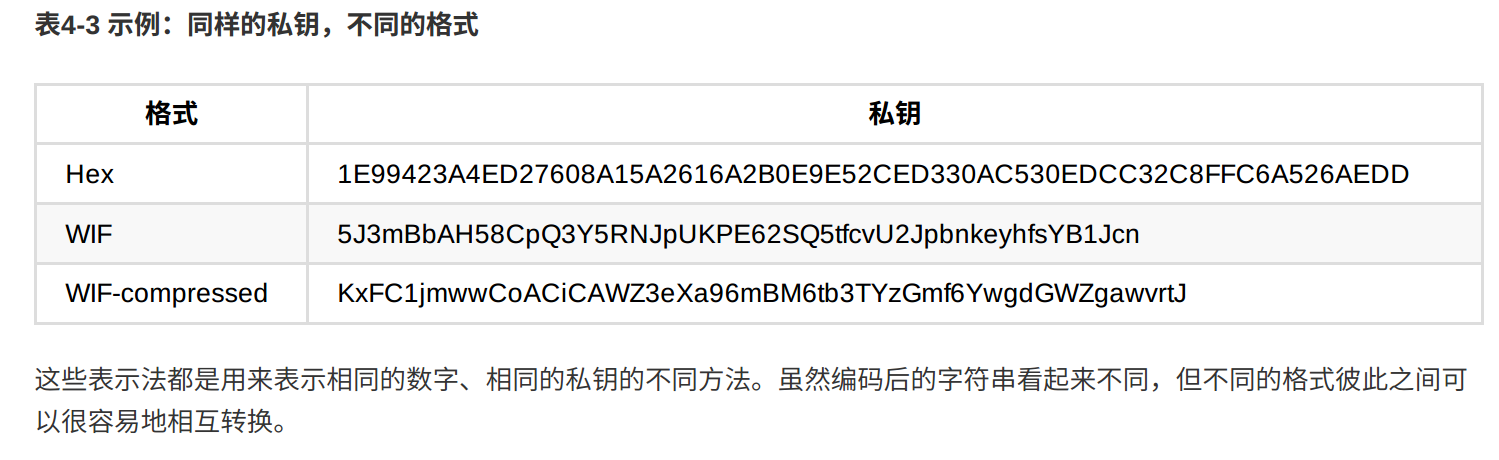

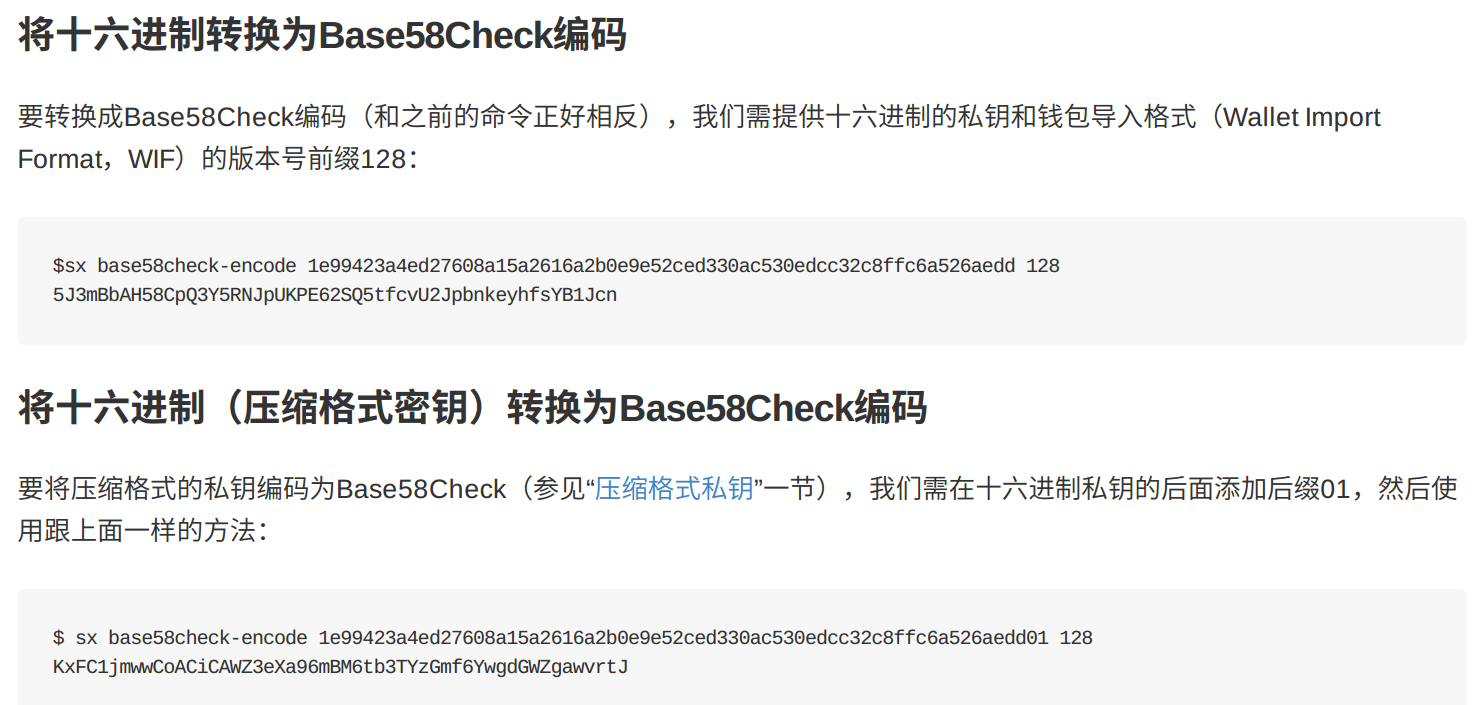

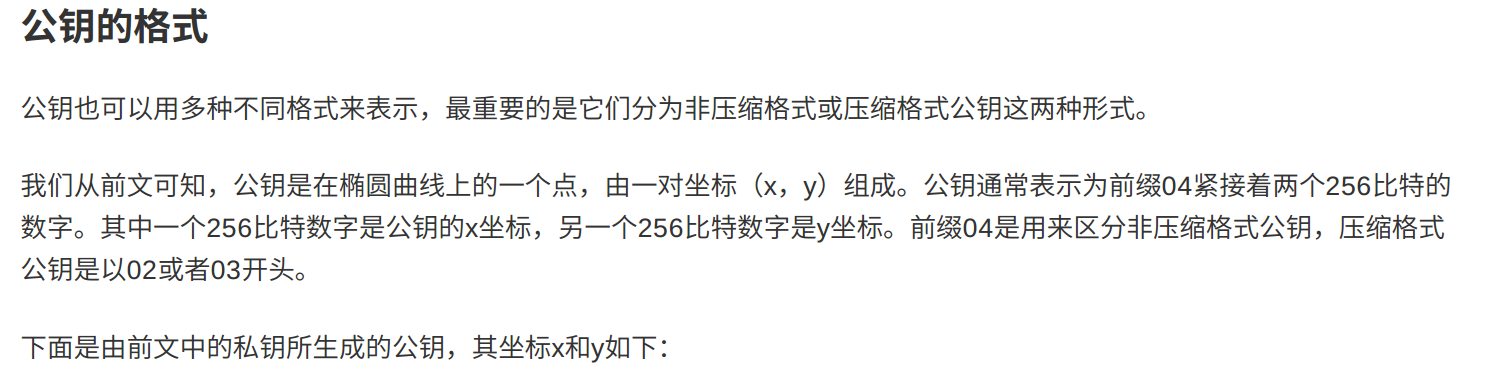

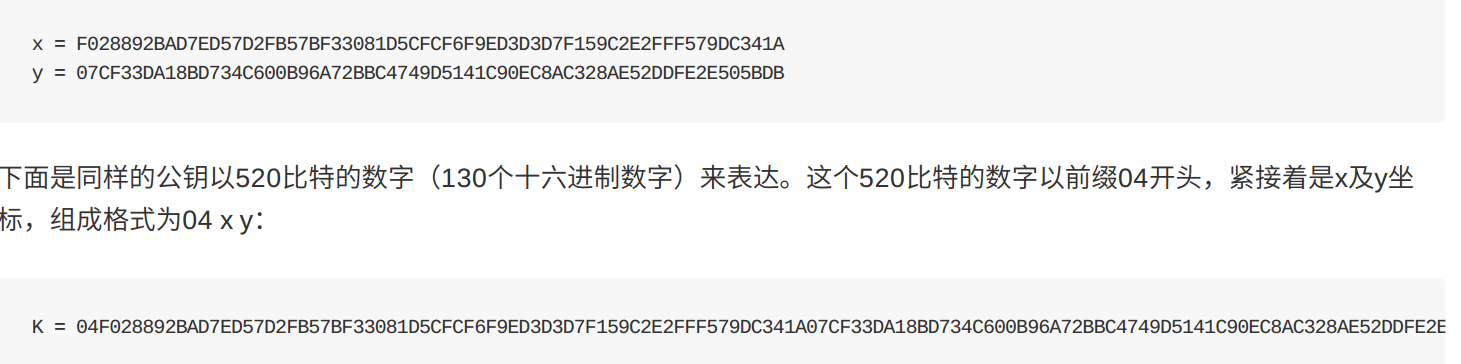

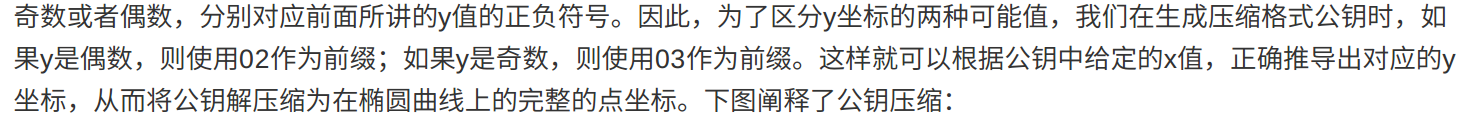

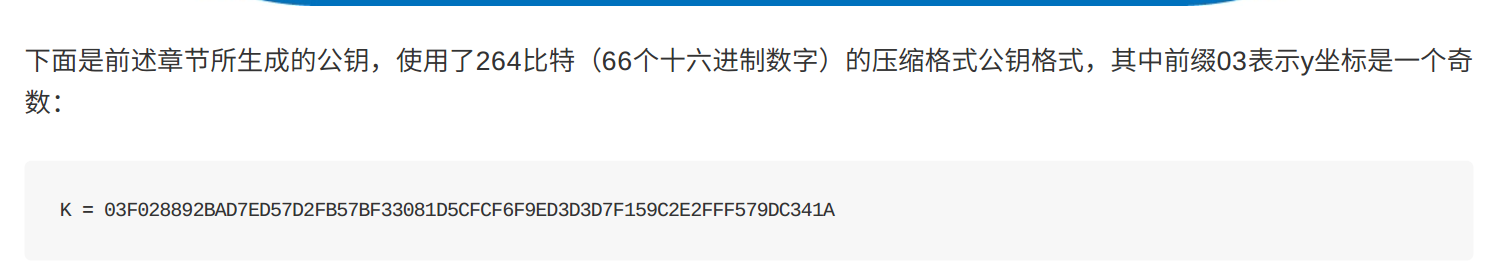

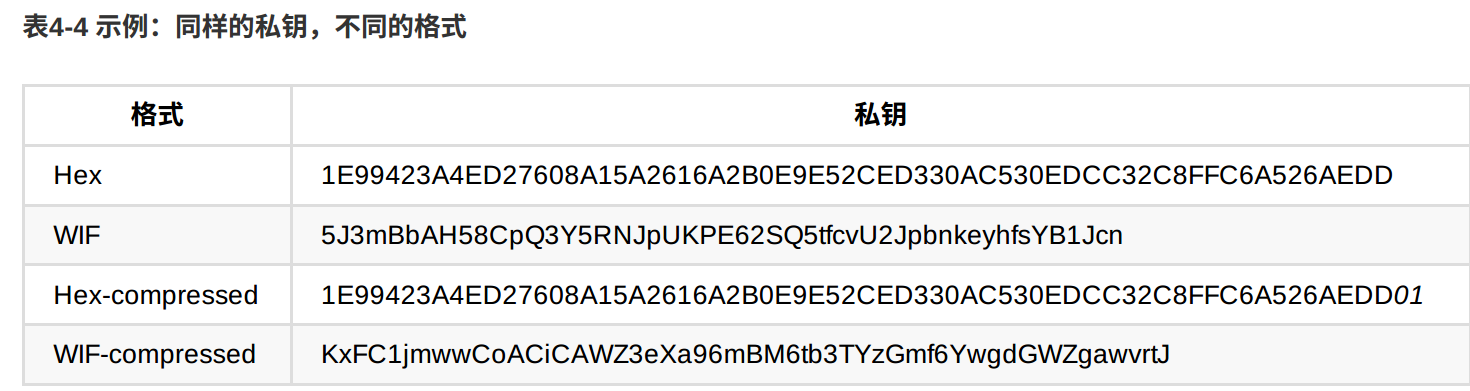

In [46]:
# 使用pybitcointools库的密钥和比特币地址的生成和格式化过程
import bitcoin
# Generate a random private key
valid_private_key = False 
while not valid_private_key:
    private_key = bitcoin.random_key()
    decoded_private_key = bitcoin.decode_privkey(private_key, 'hex')
    valid_private_key = 0 < decoded_private_key < bitcoin.N
print ("Private Key (hex) is: ", private_key)
print ("Private Key (decimal) is: ", decoded_private_key)
# Convert private key to WIF format
wif_encoded_private_key = bitcoin.encode_privkey(decoded_private_key, 'wif')
print ("Private Key (WIF) is: ", wif_encoded_private_key)
# Add suffix "01" to indicate a compressed private key
compressed_private_key = private_key + '01'
print ("Private Key Compressed (hex) is: ", compressed_private_key)
# Generate a WIF format from the compressed private key (WIF-compressed)
wif_compressed_private_key = bitcoin.encode_privkey(
bitcoin.decode_privkey(compressed_private_key, 'hex'), 'wif')
print ("Private Key (WIF-Compressed) is: ", wif_compressed_private_key)
# Multiply the EC generator point G with the private key to get a public key point
#public_key = bitcoin.base10_multiply(bitcoin.G, decoded_private_key)
public_key = bitcoin.multiply(bitcoin.G, decoded_private_key)
print ("Public Key (x,y) coordinates is:", public_key)
# Encode as hex, prefix 04
hex_encoded_public_key = bitcoin.encode_pubkey(public_key,'hex') 
print ("Public Key (hex) is:", hex_encoded_public_key)
# Compress public key, adjust prefix depending on whether y is even or odd
(public_key_x, public_key_y) = public_key 
if (public_key_y % 2) == 0:
    compressed_prefix = '02'
else:
    compressed_prefix = '03'
hex_compressed_public_key = compressed_prefix + bitcoin.encode(public_key_x, 16) 
print ("Compressed Public Key (hex) is:", hex_compressed_public_key)
# Generate bitcoin address from public key
print ("Bitcoin Address (b58check) is:", bitcoin.pubkey_to_address(public_key))
# Generate compressed bitcoin address from compressed public key
# print ("Compressed Bitcoin Address (b58check) is:",  bitcoin.pubkey_to_address(hex_compressed_public_key))

Private Key (hex) is:  e21af294cd1ebf0148bfe61a7e5000ab1d6c05b87ffca0e89db26304f063d756
Private Key (decimal) is:  102270316037792139829133177401090336757018148843574649003606662382805661767510
Private Key (WIF) is:  5KXs8uAULh28uTF3WNcJudqqTdtFddS2MtLMpNUXMFFS9zMcrEa
Private Key Compressed (hex) is:  e21af294cd1ebf0148bfe61a7e5000ab1d6c05b87ffca0e89db26304f063d75601
Private Key (WIF-Compressed) is:  L4oEHsEofue1tWpz4eNr3KcYtZoDafoT1BaSt5nUxMti2H9bRPgx
Public Key (x,y) coordinates is: (47943595542888446557333979785611926306192392506810897175454903942824154239366, 56113981110275607931610681515909815425003838153432690894996147935446232538427)
Public Key (hex) is: 0469ff1d0abcce062271f76d6e674f4401ff8379db80ae7ee78fdcfebd4eb211867c0f6346bce85deec44d0896d028a8094be5112642e1284254d9a52790311d3b
Compressed Public Key (hex) is: 0369ff1d0abcce062271f76d6e674f4401ff8379db80ae7ee78fdcfebd4eb21186
Bitcoin Address (b58check) is: 1D2RnCvsmsXcoPFANbUGweZHC46ZWKDLcz


In [45]:
import hashlib
from ecdsa import SECP256k1, SigningKey
import sys
import binascii

# 58 character alphabet used
BASE58_ALPHABET = '123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz'

def from_bytes (data, big_endian = False):
    if isinstance(data, str):
        data = bytearray(data)
    if big_endian:
        data = reversed(data)
    num = 0
    for offset, byte in enumerate(data):
        num += byte << (offset * 8)
    return num
    
def base58_encode(version, public_address):
    """
    Gets a Base58Check string
    See https://en.bitcoin.it/wiki/Base58Check_encoding
    """
    if sys.version_info.major > 2:
        version = bytes.fromhex(version)
    else:
        version = bytearray.fromhex(version)
    firstSHA256 = hashlib.sha256(version + public_address)
    print("first sha256: %s"%firstSHA256.hexdigest().upper())
    secondSHA256 = hashlib.sha256(firstSHA256.digest())
    print("second sha256: %s"%secondSHA256.hexdigest().upper())
    checksum = secondSHA256.digest()[:4]
    payload = version + public_address + checksum
    print("Hex address: %s"%binascii.hexlify(payload).decode().upper())
    if sys.version_info.major > 2:
        result = int.from_bytes(payload, byteorder="big")
    else:
        result = from_bytes(payload, True)
    # count the leading 0s
    padding = len(payload) - len(payload.lstrip(b'\0'))
    encoded = []

    while result != 0:
        result, remainder = divmod(result, 58)
        encoded.append(BASE58_ALPHABET[remainder])

    return padding*"1" + "".join(encoded)[::-1]

def get_private_key(hex_string):
    if sys.version_info.major > 2:
        return bytes.fromhex(hex_string.zfill(64))
    else:
        return bytearray.fromhex(hex_string.zfill(64))

def get_public_key(private_key):
    # this returns the concatenated x and y coordinates for the supplied private address
    # the prepended 04 is used to signify that it's uncompressed
    if sys.version_info.major > 2:
        return (bytes.fromhex("04") + SigningKey.from_string(private_key, curve=SECP256k1).verifying_key.to_string())
    else:
        return (bytearray.fromhex("04") + SigningKey.from_string(private_key, curve=SECP256k1).verifying_key.to_string())

def get_public_address(public_key):
    address = hashlib.sha256(public_key).digest()
    print("public key hash256: %s"%hashlib.sha256(public_key).hexdigest().upper())
    h = hashlib.new('ripemd160')
    h.update(address)
    address = h.digest()
    print("RIPEMD-160: %s"%h.hexdigest().upper())
    return address

if __name__ == "__main__":
    #private_key = get_private_key("FEEDB0BDEADBEEF")
    private_key = get_private_key("5b6ca460be08fd604beaf51227d1f3cfe9441eadb4cee6cd117be971f45d3da7")
    print("private key: %s"%binascii.hexlify(private_key).decode().upper())
    public_key = get_public_key(private_key)
    print("public_key: %s"%binascii.hexlify(public_key).decode().upper())
    public_address = get_public_address(public_key)
    bitcoin_address = base58_encode("00", public_address)
    print("Final address %s"%bitcoin_address)

# PubKeyToAddress将比特币公钥转换为base58编码的字符串地址
# 在PubKeyToAddress函数中，会先调用Hash160对公钥进行SHA256和RIPEMD160哈希运算
# 即对应生成过程的第三、四步

private key: 5B6CA460BE08FD604BEAF51227D1F3CFE9441EADB4CEE6CD117BE971F45D3DA7
public_key: 0469AD1F7EF2F874D38E9428B40F181F11538FC931E12EA1124DBCDEE078D89E26AA7D6F1D661E885A6D99006743CF76036D4E4A8E446A98569629FC1E6A983545
public key hash256: E383BC73A17021094F2E30C8CD17BDCBD41F1A3D155AF43E2E9B17AF8640FD5A
RIPEMD-160: 65F1143153A5A977DB990F9FEAD468BE5BBE8993
first sha256: 22BFDC213070ED0D927243FAD26563B97AFF7266D45B60C887278D2E15F6B060
second sha256: 7C6E0BA84004072B31677C516353D962BC2B86CDC9710B45763F6B3EFA481C59
Hex address: 0065F1143153A5A977DB990F9FEAD468BE5BBE89937C6E0BA8
Final address 1AJ23q5afprvrNo1J29FANekDxcUbmHNum


1AJ23q5afprvrNo1J29FANekDxcUbmHNum

In [27]:
import binascii
BASE58_ALPHABET = '123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz'
a = input("请输入")
qq=""
for i in a:
    pp = (ord(i))
    qq += str(pp)
    #print(pp)
# print(qq)
qq = int(qq)
yushu_list = []
while qq > 0:
    yushu = qq % 58
    yushu_list.insert(0,yushu)
    qq = qq // 58
    #print(qq)
# print(yushu_list)
zhuanma = "".join(i for i in [BASE58_ALPHABET[j] for j in yushu_list])
print(zhuanma)

请输入123456
E1F1U9o


In [28]:
BASE58_ALPHABET = '123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz'
xx = input("请输入您的生日:")
# print(xx)
num_list = []
for x in xx:
    num_list.append(BASE58_ALPHABET.index(x))
# print(num_list)
num = 0
for i in range(len(num_list)):
    num += num_list[i] * (58 ** (len(num_list)-1-i))
#print(num)
num = str(num)
asc_list = []
def fun(n):
    if int(n[-2:]) < 32:
        asc_list.append(n[-3:])
        q = -3
    else:
        asc_list.append(n[-2:])
        q = -2
    n = n[:q]
    if len(n) > 0:
        fun(n)
#     else:
#         print(asc_list)
fun(num)
asc_list.reverse()
adr = ''.join((chr(int(i))) for i in asc_list)
print(adr)

请输入您的生日:E1F1U9o
123456


In [59]:
from scipy import  stats
import numpy as np
sum_potention = np.sum(stats.binom.pmf(127,256,0.5))
print(sum_potention)

0.04943291528548727


In [73]:
p_256 = 2 ** 256
p_160 = 2 ** 160
p_sushu = 2**256-2**32-2**9-2**8-2**7-2**6-2**4-1
p_sql = 7237005577332262213973186563042994240829374041602525252466099000494570602495
print(p_256)
print(p_sql)
print(p_160)
print(p_sushu)
print(p_sql/p_256)

115792089237316195423570985008687907853269984665640564039457584007913129639936
7237005577332262213973186563042994240829374041602525252466099000494570602495
1461501637330902918203684832716283019655932542976
115792089237316195423570985008687907853269984665640564039457584007908834671663
0.0625
60673748286552814970469134617332836287649131506690229316674


In [29]:
import numpy as np
max_private_key = 0b1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111010101011101101110011100110101011110100100010100000001110111011111111010010010111101000110011010000001101100100000101000001
rand_256 = np.random.randint(0,2,size = (1,128))
print(rand_256)
rand_256=list(rand_256)
list1 = []
for i in rand_256:
    for j in i:
        list1.append(j)
#         print(j)
# print(list1)
pp = "".join(str(i) for i in list1)
print(pp)

[[0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1
  1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1
  0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0
  1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1]]
00010111100001111101001001011011110111100110101111110011001011100011001100101011000010101100110010111010100010001010011001100111


In [57]:
max_privite_key = 0xfffffffffffffffffffffffffffffffebaaedce6af48a03bbfd25e8cd0364141
print(bin(max_privite_key))
print(hex(0b1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111010101011101101110011100110101011110100100010100000001110111011111111010010010111101000110011010000001101100100000101000001))

0b1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111010111010101011101101110011100110101011110100100010100000001110111011111111010010010111101000110011010000001101100100000101000001
0xfffffffffffffffffffffffffffffffebaaedce6af48a03bbfd25e8cd0364141
